In [40]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
from datetime import datetime, timedelta, date

import string, ffmpeg
import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/anaconda3/bin/ffmpeg' # '/opt/anaconda3/lib/python3.8/site-packages/ffmpeg'

from matplotlib import animation

In [2]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡')

def TxNormalize(text):
    
    return word_tokenize(text.lower().translate(Punct_List))

def respuesta(texto):
    Tokens_List.append(texto)
    TfidfVec = TfidfVectorizer(tokenizer = TxNormalize) 
    tfidf = TfidfVec.fit_transform(Tokens_List)
    Tokens_List.remove(texto)
    vals = cosine_similarity(tfidf[-1], tfidf)
    flat = vals.flatten()
    flat.sort()
    
    return Tokens_List[vals.argsort()[0][-2]]

# Datos Vacunación

In [3]:
url = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_'

for i in range(10):
    try:
        df = (pd.read_excel(url + (datetime.now() - timedelta(days = + i)).strftime("%Y%m%d") + '.ods', engine="odf")
                .set_index('Unnamed: 0'))
        break
        
    except:
        pass
    
df.head()

,Dosis entregadas Pfizer (1),Dosis entregadas Moderna (1),Dosis entregadas AstraZeneca (1),Total Dosis entregadas (1),Dosis administradas (2),% sobre entregadas,Nº Personas vacunadas(pauta completada),Fecha de la última vacuna registrada (2)
Unnamed: 0,,,,,,,,
Andalucía,475110,36300,34500,545910,431642,0.790683,176731,2021-02-11
Aragón,81045,6300,5400,92745,88297,0.952041,35659,2021-02-11
Asturias,83975,6300,4200,94475,78446,0.830336,32946,2021-02-11
Baleares,42480,3200,4800,50480,40624,0.804754,16683,2021-02-11
Canarias,93570,7000,8900,109470,99316,0.907244,40779,2021-02-11


# Datos población

In [4]:
url = 'https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/2853.csv?nocab=1'

poblacion = pd.read_csv(url, error_bad_lines=False, sep=';', header=0)

poblacion = poblacion[(poblacion['Comunidades y Ciudades Autónomas'] != 'Total') 
                      & (poblacion['Periodo'] == 2020)].pivot(index = 'Comunidades y Ciudades Autónomas'
                                                             , columns = 'Sexo'
                                                             , values = 'Total')

Tokens_List = sent_tokenize(" ".join(review for review in df.index + '.'), 'spanish')
matriz = {}

for i in poblacion.index.values:
    matriz[i] = respuesta(i.replace('Balears','Baleares'))[:-1]
            
poblacion.index = poblacion.index.map(matriz)

poblacion.head()

Sexo,Hombres,Mujeres,Total
Comunidades y Ciudades Autónomas,,,
Andalucía,4.170.605,4.293.806,8.464.411
Aragón,656.056,673.335,1.329.391
Asturias,486.066,532.718,1.018.784
Baleares,584.298,587.245,1.171.543
Canarias,1.076.185,1.099.767,2.175.952


# Datos edad x comunidad

In [5]:
Url = 'https://www.ine.es/jaxi/files/_px/es/csv_bdsc/t20/e245/p08/l0/02003.csv_bdsc?nocab=1'

xx = pd.read_csv(Url, error_bad_lines=False, sep=';', header=0)

xx = xx[(xx['Españoles/Extranjeros']=='TOTAL')
        & (xx['Sexo']=='Ambos sexos')
        & (xx['Año']==2020)
        & (xx['Edad (año a año)']!='TOTAL EDADES')
        & (xx['Comunidades']!='TOTAL ESPAÑA')]

matriz = {}

for i in xx[(xx['Comunidades']!='TOTAL ESPAÑA')]['Comunidades'].unique():
    matriz[i] = respuesta(i.lower().replace('balears','baleares'))[:-1]

xx['Edad'] = (xx['Edad (año a año)']
              .str.replace(' años','')
              .str.replace(' año','')
              .str.replace(' y más','')
              .astype('int64', copy=False))

xx.Edad = xx.Edad.map(lambda x: 'Ancianos' if x >= 85 else 'Resto')
xx.Comunidades = xx.Comunidades.map(matriz)

xx.Total = pd.to_numeric(xx.Total.str.replace('.',''), errors='coerce')
xx = (pd.pivot_table(xx, index = 'Comunidades'
                    , columns= 'Edad'
                    , values = ['Total']
                    , aggfunc=[np.sum])
      .droplevel(0, axis=1)
      .droplevel(0, axis=1) 
     )

xx.Ancianos = xx.Ancianos / (xx.Ancianos + xx.Resto) * 100

xx.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Edad,Ancianos,Resto
Comunidades,,
Andalucía,2.493369,8253362.0
Aragón,4.349736,1271566.0
Asturias,5.022360,967617.0
Baleares,2.226039,1145464.0
C. Valenciana,2.852955,4913069.0


In [6]:
df = (df.merge(poblacion, left_index=True, right_index=True)
      .merge(xx['Ancianos'], left_index=True, right_index=True)
      .rename(columns = {'Dosis entregadas Pfizer (1)':'Dosis Pfizer'
         , 'Dosis entregadas Moderna (1)': 'Dosis Moderna'
         , 'Total Dosis entregadas (1)': 'Dosis'
         , 'Dosis entregadas AstraZeneca (1)': 'Dosis AstraZeneca'
         , 'Dosis administradas (2)': 'Puestas'
         , '% sobre entregadas': 'Usadas'
         , 'Nº Personas vacunadas(pauta completada)':'Inmunizados'
         , 'Fecha de la última vacuna registrada (2)':'Fecha_datos'
        }))

df['PrimeraDosis'] = df.Puestas - df.Inmunizados
df.Total = df.Total.str.replace('.','').astype('int64', copy=False)
df['Vac1'] = df.PrimeraDosis / df.Total * 100
df['Vac2'] = df.Inmunizados / df.Total * 100

df.sort_values(by='Vac1', ascending=False)
    
df.head()

,Dosis Pfizer,Dosis Moderna,Dosis AstraZeneca,Dosis,Puestas,Usadas,Inmunizados,Fecha_datos,Hombres,Mujeres,Total,Ancianos,PrimeraDosis,Vac1,Vac2
Andalucía,475110,36300,34500,545910,431642,0.790683,176731,2021-02-11,4.170.605,4.293.806,8464411,2.493369,254911,3.011562,2.087930
Aragón,81045,6300,5400,92745,88297,0.952041,35659,2021-02-11,656.056,673.335,1329391,4.349736,52638,3.959557,2.682356
Asturias,83975,6300,4200,94475,78446,0.830336,32946,2021-02-11,486.066,532.718,1018784,5.022360,45500,4.466109,3.233855
Baleares,42480,3200,4800,50480,40624,0.804754,16683,2021-02-11,584.298,587.245,1171543,2.226039,23941,2.043544,1.424019
Canarias,93570,7000,8900,109470,99316,0.907244,40779,2021-02-11,1.076.185,1.099.767,2175952,2.097197,58537,2.690179,1.874076


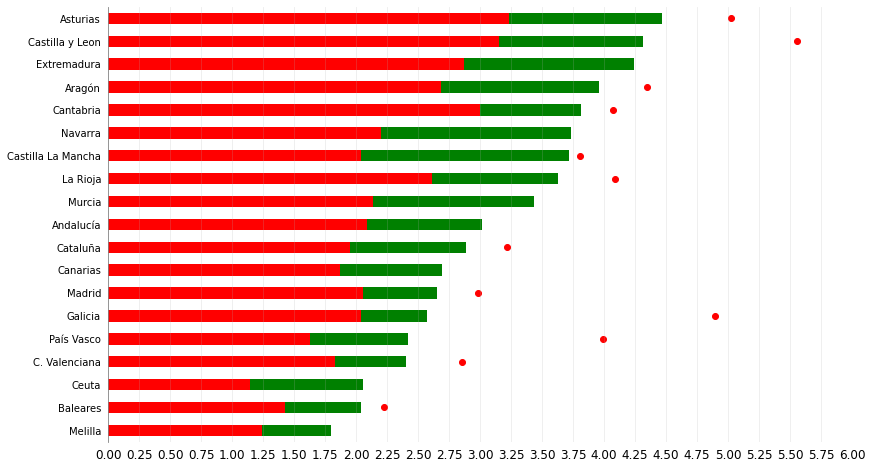

In [7]:
df.sort_values(by='Vac1', ascending=True, inplace = True)
df['vc'] = df.Vac1 - df.Vac2
df[['Vac2','vc']].plot(kind = 'barh'
                       , stacked = True
                       , legend = None
                       , color = ['red','green']
                       , figsize = (16 / 1.2, 8)
                        )

plt.scatter(df.Ancianos, df.index, color= 'red')
plt.grid(axis='x', alpha=0.25)

[spine.set_visible(False) for spine in plt.gca().spines.values()]
plt.gca().tick_params(left = False, bottom = False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['left'].set_color('grey')

vals = plt.gca().get_xticks()
vals = np.linspace(start = vals.min(), stop = vals.max(), num = len(vals) * 4 - 3)

plt.gca().set_xticks(vals)
plt.gca().set_xticklabels(['{:3.2f}'.format(x) for x in vals], fontsize = 12)

plt.show()

In [41]:
url = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_'
df=None
for i in range(100):
    try:
        df = (pd.read_excel(url + (datetime.now() - timedelta(days = + i)).strftime("%Y%m%d") + '.ods', engine="odf")
              .rename(columns = {'Dosis entregadas Pfizer (1)':'Dosis Pfizer'
                                 , 'Dosis entregadas (1)':'Dosis Pfizer'
                                 , 'Dosis entregadas AstraZeneca (1)': 'Dosis AstraZeneca'
                                 , 'Dosis entregadas Moderna (1)': 'Dosis Moderna'
                                 , 'Total Dosis entregadas (1)': 'Dosis'
                                 , 'Dosis administradas (2)': 'Puestas'
                                 , '% sobre entregadas': 'Usadas'
                                 , 'Unnamed: 0': 'Comunidad'
                                 , 'Nº Personas vacunadas(pauta completada)':'Pauta Completa'
                                 , 'Fecha de la última vacuna registrada (2)':'Fecha'
                            })
              .set_index('Fecha')
              .loc[lambda df: df.Comunidad != 'Totales']
              .append(df)
              .fillna(0))
        
    except:
        pass

df = (df
       .reset_index()
       .set_index('Comunidad')
       .merge(poblacion, left_index=True, right_index=True)
       .reset_index()
       .set_index('Fecha')
       .drop(['Hombres','Mujeres'], axis = 1)
       .rename(columns = {'index': 'Comunidad'})
      )

df = (df
      .assign(Vacunados = np.array((df.Puestas - df['Pauta Completa']) / df.Total.str.replace('.','').astype(int) * 100))
      .assign(Inmunizados = np.array(df['Pauta Completa'] / df.Total.str.replace('.','').astype(int) * 100))
      .assign(Entregadas = np.array((-df['Dosis Pfizer'] - df['Dosis Moderna'] - df['Dosis AstraZeneca'] + df.Puestas)/ df.Total.str.replace('.','').astype(int) * 100))
      .loc[ :date.today().isoformat()]
     )

df.tail()

,Comunidad,Dosis Pfizer,Puestas,Usadas,Dosis Moderna,Dosis,Pauta Completa,Dosis AstraZeneca,Total,Vacunados,Inmunizados,Entregadas
Fecha,,,,,,,,,,,,
2021-02-07,País Vasco,91080,72979,0.770796,3600.0,94680.0,24002.0,0.0,2.220.504,2.205670,1.080926,-0.977301
2021-02-08,País Vasco,91080,75634,0.728792,3600.0,103780.0,26299.0,9100.0,2.220.504,2.221793,1.184371,-1.267550
2021-02-09,País Vasco,107460,75634,0.607697,7900.0,124460.0,26299.0,9100.0,2.220.504,2.221793,1.184371,-2.198870
2021-02-10,País Vasco,107460,84459,0.678604,7900.0,124460.0,32897.0,9100.0,2.220.504,2.322085,1.481511,-1.801438
2021-02-11,País Vasco,107460,89883,0.722184,7900.0,124460.0,36125.0,9100.0,2.220.504,2.420982,1.626883,-1.557169


In [42]:
def nice_axes(ax, ax2, vals, a, b):
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('grey')
    ax.set_xticks(vals)
    ax.set_xticklabels(['{:3.1f} %'.format(x) if (x < a and x != 0)  else '{:3.1f} %'.format(vals.max() - x) if (vals.max() - x < - b and  vals.max() - x != 0) else None  for x in vals]
                       , fontsize = 18)
    
    ax.grid(axis='x', alpha=0.25)
    ax.yaxis.set_tick_params(labelsize=18)
    
    ax2.set_xticks(vals*-1)
    [spine.set_visible(False) for spine in ax2.spines.values()]
    ax2.set_xticklabels('')
    ax2.tick_params(left = False, top = False, bottom = False)
    ax.tick_params(left = False, bottom = False)
    
def pivot_table(df, val):
    
    return (df.reset_index()
            .drop_duplicates(['Fecha', 'Comunidad'], keep= 'last')
            .pivot(index = 'Fecha', columns='Comunidad', values= val)
            .fillna(0))


colors = plt.cm.tab20(range(len(df.Comunidad.unique())))
i = df.index.sort_values(ascending = True).max().isoformat()

vals = np.linspace(start = 0
                   , stop = int(df.loc[i].Vacunados.max() - df.loc[i].Entregadas.min()) + 1
                   , num = int(df.loc[i].Vacunados.max() - df.loc[i].Entregadas.min()) * 2 +3)

fig, ax = plt.subplots(nrows = 1
                             , ncols = 1
                             , figsize=(20,10), dpi = 960
                             , tight_layout=True)
ax2 = ax.twiny()

for AX, val, alpha in zip([ax, ax, ax2], ['Vacunados', 'Inmunizados','Entregadas'],[.6,1,.4]):
    
    datos = pivot_table(df, val)
    
    if val == 'Vacunados':
        orden = datos.loc[i].rank(method='first')
        tick = datos.loc[i].index
        
    AX.barh(y = orden
                , width = datos.loc[i].values
                , color = colors
                , tick_label= tick
                , alpha = alpha
               )
    
nice_axes(ax, ax2, vals, df.loc[i].Vacunados.max(), df.loc[i].Entregadas.min())  

fig.savefig('vacunas.jpg')
